# Denoising Diffusion Implicit Models - DDIM with tinyai

# Setup

Cloning a repository from github and installing it on cloud machine for this run

In [ ]:
! git clone https://github.com/GalaxUniv/tinyai.git
! pip install -e tinyai/.
! pip uninstall torchaudio -y

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *
from tinyai.sgd import *
from tinyai.resnet import *
from tinyai.augment import *
from tinyai.accel import *
from tinyai.fid import *

In [ ]:
from fastprogress.fastprogress import progress_bar

In [ ]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

In [ ]:
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

## Diffusers DDPM Scheduler
Lets try to get it working first using the diffusers library than we will build our own one from scratch

We did create a custom `UNET` class in previous notebook where we modified the forward method to work with our schedulers and whole package, we trained the model and, than we saved the model to pickle file. \
When we are loading the pickle file we are basicaly loading in class names there is no code stored so if we modify the class again (so it will work properly with diffuers schedulers) and load the model, the modified class will be loaded.

In [ ]:
class UNet(UNet2DModel): pass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = torch.load('drive/MyDrive/models/tinyai/fashion_ddpm3_25.pkl').cuda()

In [ ]:
sched = DDPMScheduler(beta_end=0.01)

In [ ]:
x_t = torch.randn((32,1,32,32)).cuda()

In [ ]:
t = 999
t_batch = torch.full((len(x_t),), t, device=x_t.device, dtype=torch.long)
with torch.no_grad(): noise = model(x_t, t_batch).sample

In [ ]:
res = sched.step(noise, t, x_t)

In [ ]:
res.prev_sample.shape

torch.Size([32, 1, 32, 32])

In [ ]:
sz = (2048,1,32,32)

In [ ]:
%%time
x_t = torch.randn(sz).cuda()
preds = []

for t in progress_bar(sched.timesteps):
    with torch.no_grad(): noise = model(x_t, t).sample
    x_t = sched.step(noise, t, x_t).prev_sample
    preds.append(x_t.float().cpu())

CPU times: user 23min 51s, sys: 7.13 s, total: 23min 59s
Wall time: 25min 6s


In [ ]:
s = preds[-1].clamp(-0.5,0.5)*2

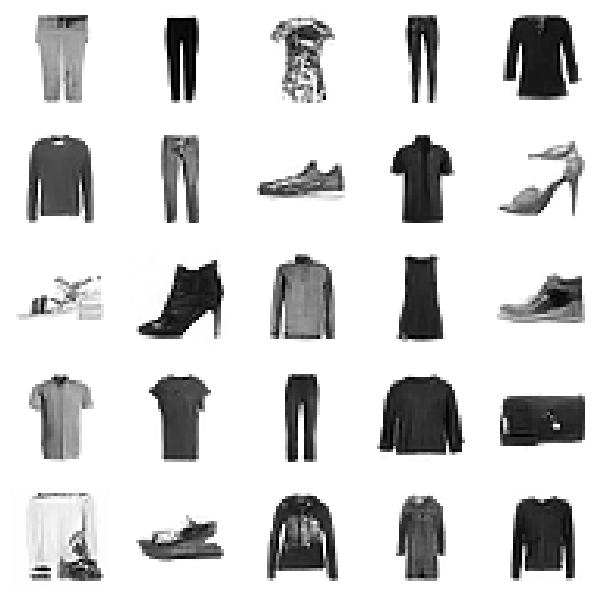

In [ ]:
show_images(s[:25], imsize=1.5)

We load in the classifier model

In [ ]:
cmodel = torch.load('drive/MyDrive/models/tinyai/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [ ]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [ ]:
ie.fid(s),ie.kid(s)

(4.8726806640625, -0.005663231946527958)

In [ ]:
ie.fid(xb),ie.kid(xb)

(1.968994140625, 0.006928978953510523)

## Diffusers DDIM Scheduler

In [ ]:
sched = DDIMScheduler(beta_end=0.01)
# We set a ammount of steps
sched.set_timesteps(333)

In [ ]:
def diff_sample(model, sz, sched, **kwargs):
    x_t = torch.randn(sz).cuda()
    preds = []
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t).sample
        x_t = sched.step(noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    return preds

In [ ]:
preds = diff_sample(model, sz, sched, eta=1.) # eta -> ammont of noise added 1.0 -> 100% noise
s = (preds[-1]*2).clamp(-1,1)

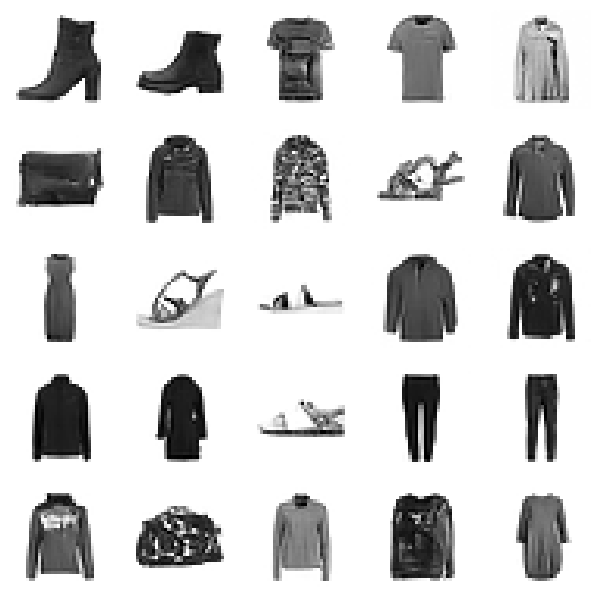

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s),ie.kid(s)

(4.6851806640625, 0.04957564175128937)

In [ ]:
sched.set_timesteps(200)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

(6.6826171875, 0.01652786135673523)

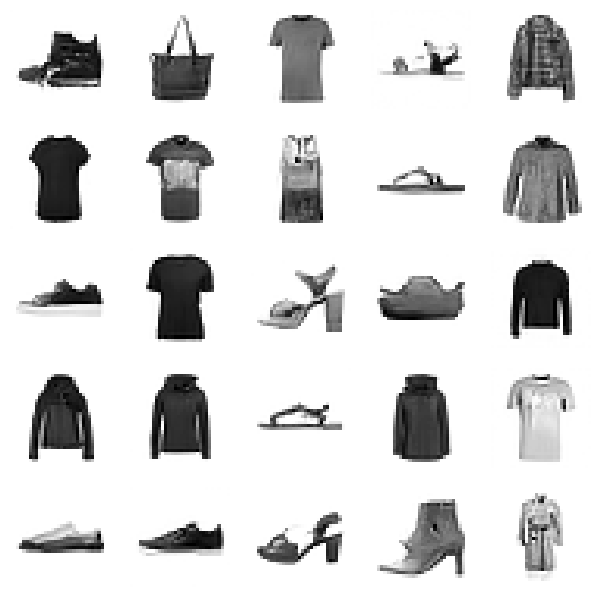

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
sched.set_timesteps(100)
preds = diff_sample(model, sz, sched, eta=1.)

In [ ]:
s = (preds[-1]*2).clamp(-1,1)

In [ ]:
ie.fid(s),ie.kid(s)

(14.237548828125, 0.11712240427732468)

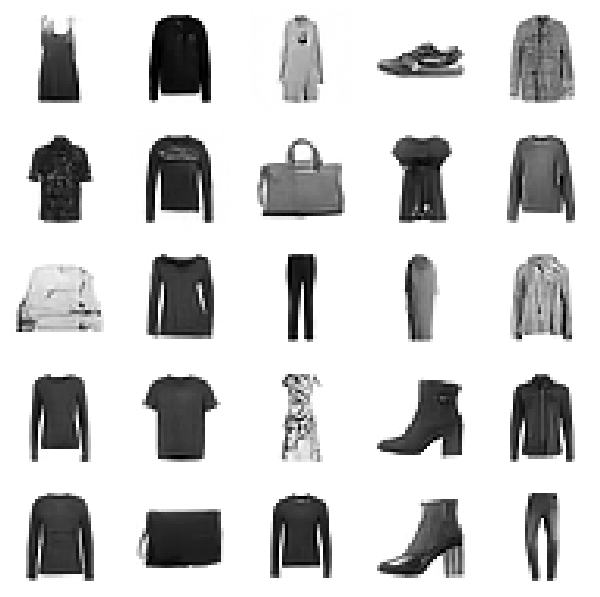

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
sched.set_timesteps(50)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

(17.12158203125, 0.11895455420017242)

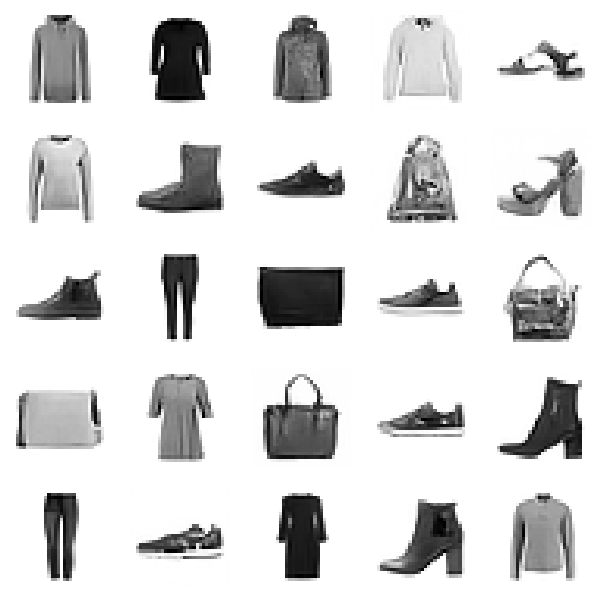

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
sched.set_timesteps(25)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

(28.88720703125, 0.1971816122531891)

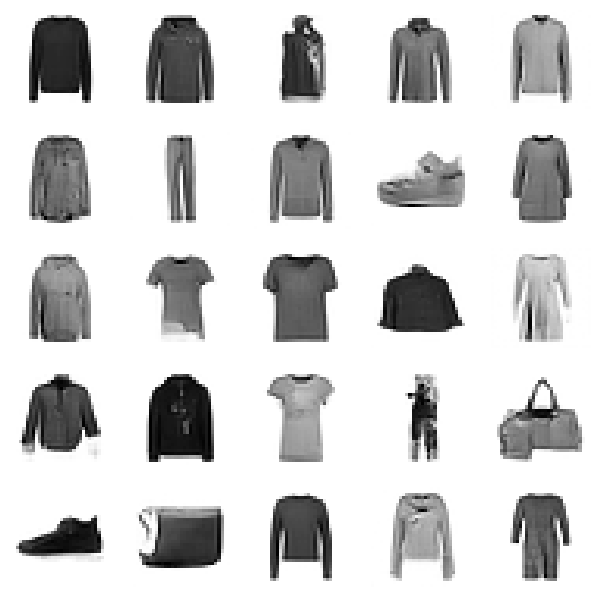

In [ ]:
show_images(s[:25], imsize=1.5)

## Implementing DDIM

In [ ]:
from types import SimpleNamespace

In [ ]:
n_steps=1000

In [ ]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [ ]:
sc = linear_sched(betamax=0.01, n_steps=n_steps)
abar = sc.abar

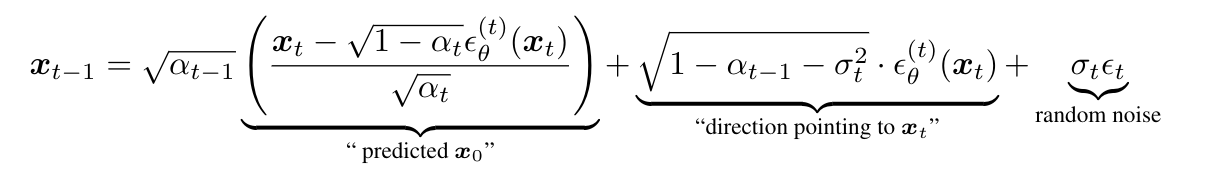

Note that the code is a bit different than a equasion since many papers use different notation, for example: \
$ \bar \beta_t $ = $ \sqrt{1-\alpha_t}$  
$ \bar \alpha_t $ = $ \sqrt{\alpha_t} $

In [ ]:
def ddim_step(x_t, t, noise, a_bar_t, a_bar_t1, beta_bar_t, beta_bar_t1, eta):
    variation = ((beta_bar_t1/beta_bar_t) * (1-a_bar_t/a_bar_t1))
    sig = variation.sqrt()*eta
    x_0_hat = ((x_t-beta_bar_t.sqrt()*noise) / a_bar_t.sqrt())
    x_t = a_bar_t1.sqrt()*x_0_hat + (beta_bar_t-sig**2).sqrt()*noise
    if t>0: x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_t

In [ ]:
@torch.no_grad()
def sample(f, model, sz, n_steps, skips=1, eta=1.):
    tsteps = list(reversed(range(0, n_steps, skips)))
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i,t in enumerate(progress_bar(tsteps)):
        abar_t1 = abar[tsteps[i+1]] if t > 0 else torch.tensor(1)
        noise = model(x_t,t).sample
        x_t = f(x_t, t, noise, abar[t], abar_t1, 1-abar[t], 1-abar_t1, eta)
        preds.append(x_t.float().cpu())
    return preds

In [ ]:
%%time
samples = sample(ddim_step, model, sz, 1000, 10)

CPU times: user 2min 29s, sys: 195 ms, total: 2min 29s
Wall time: 2min 30s


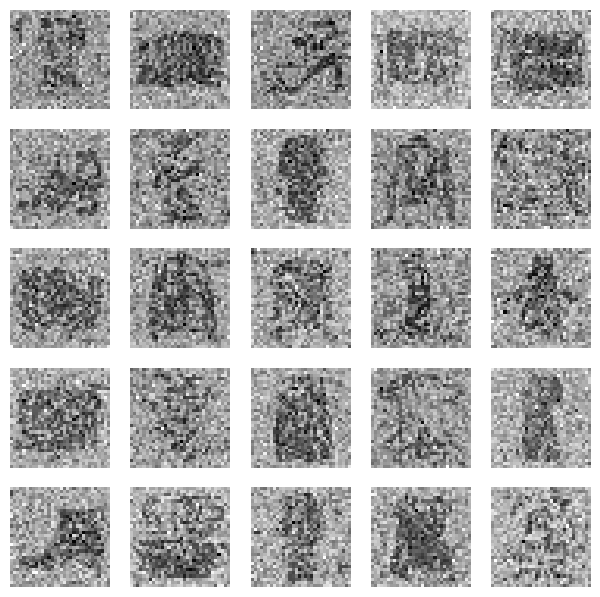

In [ ]:
s = (samples[-1]*2)#.clamp(-1,1)
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s),ie.kid(s)

(1204.5045166015625, 16.456478118896484)

## Triangular noise

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    t = np.random.triangular(0, 0.5, 1, (n,))*n_steps
    t = tensor(t, dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

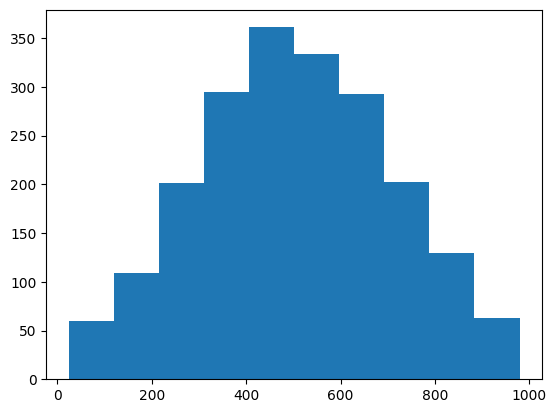

In [ ]:
(xt,t),ε = noisify(xb,abar)
plt.hist(t);